# Importing Libraries

In [1]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datasets import Array2D, Array3D, ClassLabel, Dataset, Features, Sequence, Value
from PIL import Image
from sklearn.model_selection import train_test_split 
from tqdm import tqdm
from transformers import AdamW, LayoutLMv2FeatureExtractor, LayoutLMForSequenceClassification, LayoutLMv2ForSequenceClassification, LayoutLMv2Processor, LayoutLMv2Tokenizer

C:\Users\snatt\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Hyper-parameters

In [2]:
dataset_path = "./Tobacco3482-jpg"
input_size = 224
ch = 3
test_size = 0.2
epochs = 20
lr = 5e-5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Vizulization

In [3]:
def count_exp(path):
    c = {}
    for expression in os.listdir(path):
        class_path = os.path.join(path, expression)
        c[expression] = len(os.listdir(class_path))
    df = pd.DataFrame(c, index=["count"])
    return df

In [4]:
count = count_exp(dataset_path)
print(count)

       ADVE  Email  Form  Letter  Memo  News  Note  Report  Resume  Scientific
count   231    600   432     568   621   189   202     266     121         262


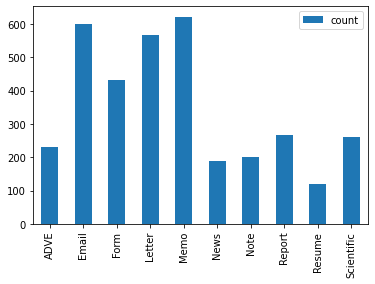

In [5]:
count.transpose().plot(kind='bar');

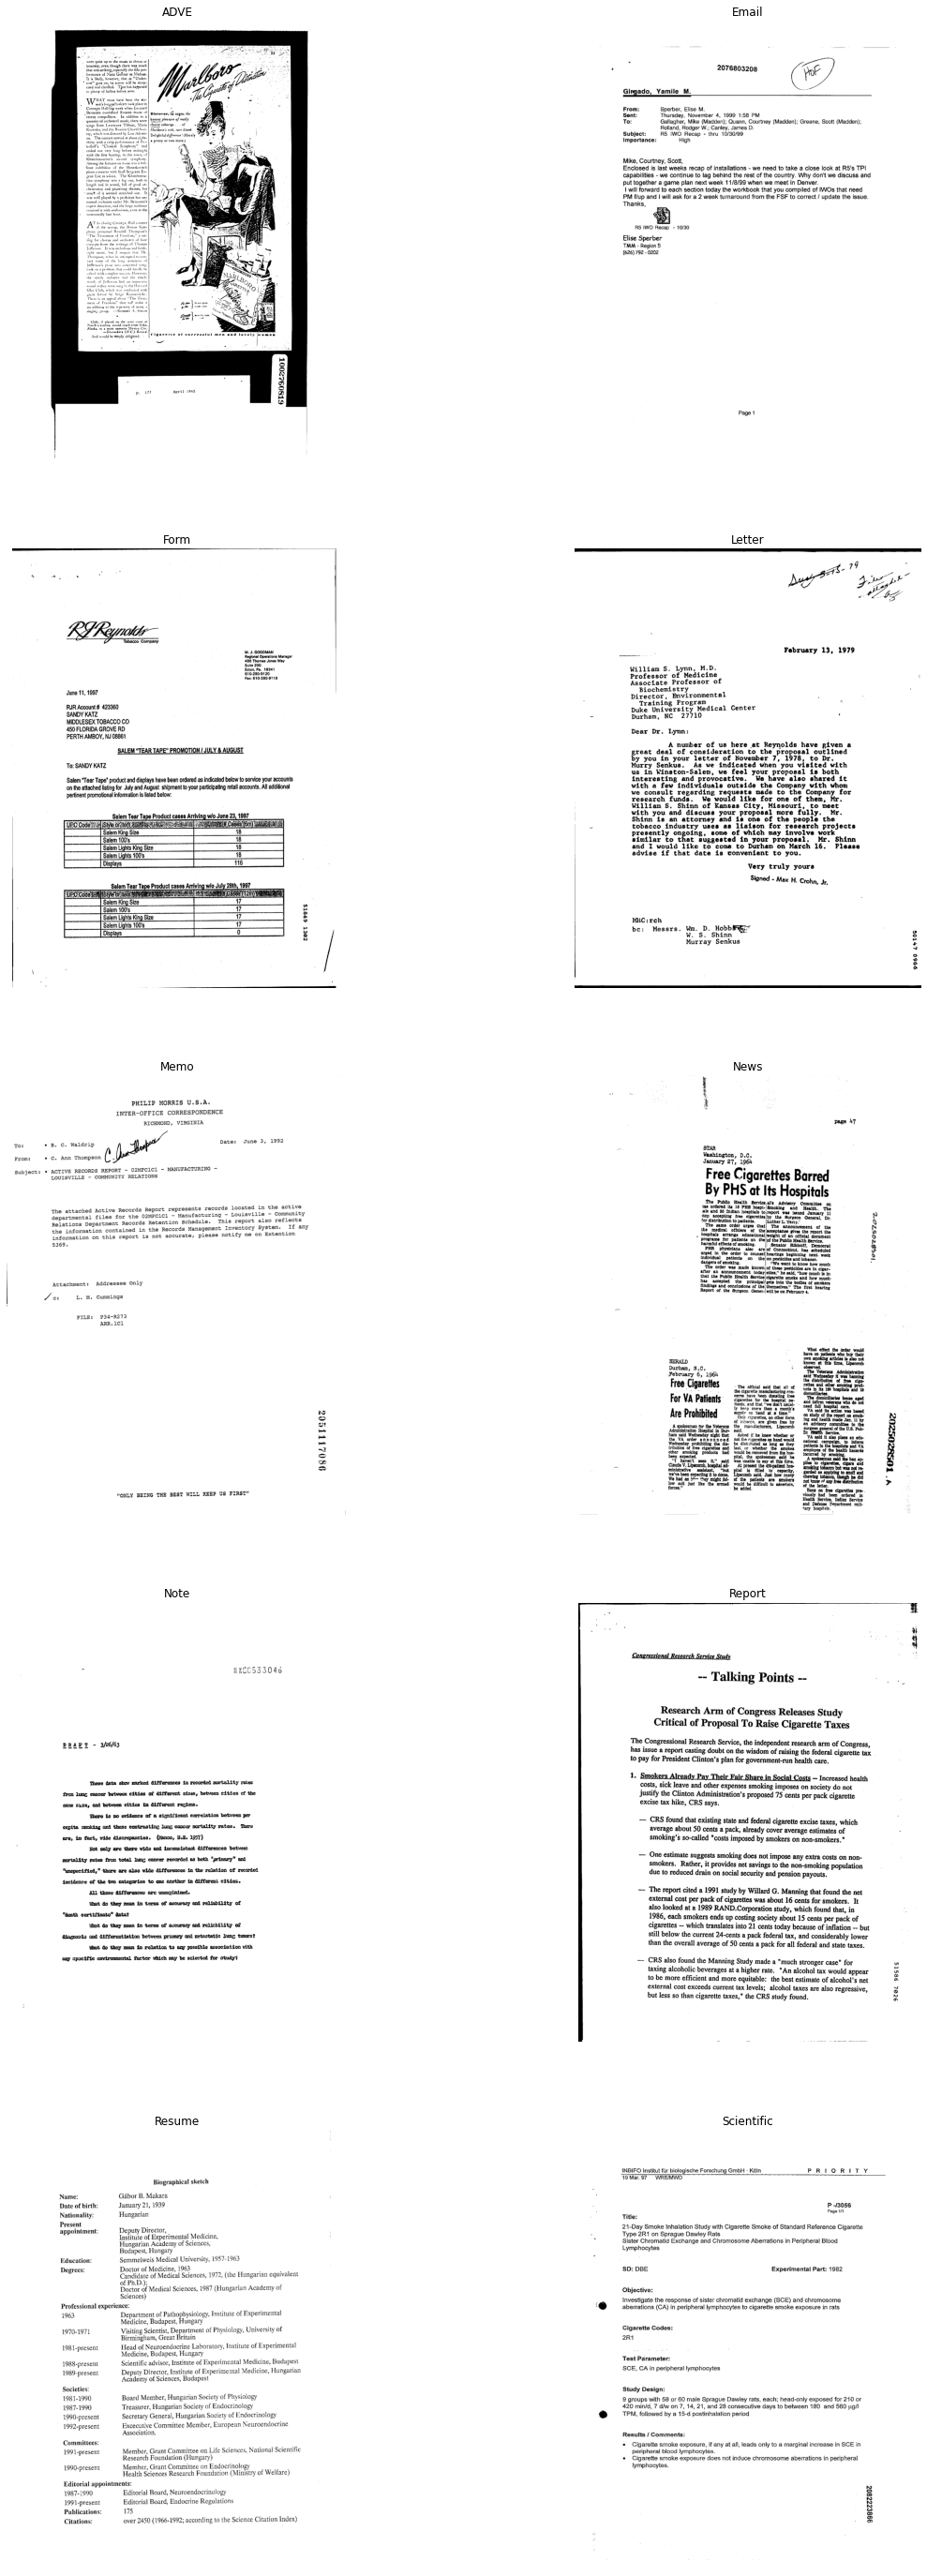

In [6]:
def plot_images(path):
    plt.figure(figsize=(20,50))
    for idx, label in enumerate(os.listdir(path)):
        label_path = os.path.join(path, label)
        images = os.listdir(label_path)
        
        plt.subplot(5,2,idx+1)
        k = np.random.randint(0, len(images))
        im = Image.open(os.path.join(label_path, images[k]))
        plt.imshow(im, cmap='gray')
        plt.axis('off')
        plt.title(label)
        
    plt.show()
        
plot_images(dataset_path)

# Data Pre-processing

In [7]:
labels = [label for label in os.listdir(dataset_path)]
id2label = {v: k for v, k in enumerate(labels)}
label2id = {k: v for v, k in enumerate(labels)}
print(labels)
print(label2id)

['ADVE', 'Email', 'Form', 'Letter', 'Memo', 'News', 'Note', 'Report', 'Resume', 'Scientific']
{'ADVE': 0, 'Email': 1, 'Form': 2, 'Letter': 3, 'Memo': 4, 'News': 5, 'Note': 6, 'Report': 7, 'Resume': 8, 'Scientific': 9}


In [8]:
images = []
labels = []

for label_folder, _, file_names in os.walk(dataset_path):
    if label_folder != dataset_path:
        label = label_folder.split("/")[-1]
        for _, _, image_names in os.walk(label_folder):
            relative_image_names = []
            for image_file in image_names:
                relative_image_names.append(
                    dataset_path + "/" + label + "/" + image_file)
            images.extend(relative_image_names)
            labels.extend([label] * len(relative_image_names))

data = pd.DataFrame.from_dict({'image_path': images, 'label': labels})

labels = list(set(labels))
data.head()

,image_path,label
0,./data/tobacco3482//ADVE/0000136188.jpg,ADVE
1,./data/tobacco3482//ADVE/0000435350.jpg,ADVE
2,./data/tobacco3482//ADVE/0000556056.jpg,ADVE
3,./data/tobacco3482//ADVE/0030048095.jpg,ADVE
4,./data/tobacco3482//ADVE/0030048989.jpg,ADVE


In [9]:
data.shape

(3492, 2)

In [10]:
print("\n[INFO] Checking Dataset..")
c = 0
for index, row in data.iterrows():
    im_path, label = row
    try:
        im = Image.open(im_path).convert("RGB")
    except Exception as e:
        print(e)
        c += 1
        data.drop(index, inplace=True)
        
print(f"done found {c} corrupt images\n")


[INFO] Checking Dataset..
cannot identify image file './data/tobacco3482//ADVE/Thumbs.db'
cannot identify image file './data/tobacco3482//Email/Thumbs.db'
cannot identify image file './data/tobacco3482//Form/Thumbs.db'
cannot identify image file './data/tobacco3482//Letter/Thumbs.db'
cannot identify image file './data/tobacco3482//Memo/Thumbs.db'
cannot identify image file './data/tobacco3482//News/Thumbs.db'
cannot identify image file './data/tobacco3482//Note/Thumbs.db'
cannot identify image file './data/tobacco3482//Report/Thumbs.db'
cannot identify image file './data/tobacco3482//Resume/Thumbs.db'
cannot identify image file './data/tobacco3482//Scientific/Thumbs.db'
done found 10 corrupt images



# Train-Test Split

In [11]:
train_df, test_df = train_test_split(data, test_size=test_size)

print(f"Train Len:: {len(train_df)}\tTest Len:: {len(test_df)}")

Train Len:: 2785	Test Len:: 697


In [12]:
train_df.label.value_counts()

Memo          503
Email         486
Letter        447
Form          345
Scientific    209
Report        202
ADVE          177
News          165
Note          157
Resume         94
Name: label, dtype: int64

In [13]:
test_df.label.value_counts()

Letter        120
Memo          117
Email         113
Form           86
Report         63
ADVE           53
Scientific     52
Note           44
Resume         26
News           23
Name: label, dtype: int64

In [14]:
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Tokenizer

In [15]:
feature_extractor = LayoutLMv2FeatureExtractor()
tokenizer = LayoutLMv2Tokenizer.from_pretrained("microsoft/layoutlmv2-base-uncased")
processor = LayoutLMv2Processor(feature_extractor, tokenizer)


# we need to define custom features
features = Features({
    'image': Array3D(dtype="int64", shape=(ch, input_size, input_size)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'token_type_ids': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': ClassLabel(num_classes=len(labels), names=labels),
})

# Encoding data into Dataset format

In [16]:
def preprocess_data(examples):
    # take a batch of images
    images = [Image.open(path).convert("RGB") for path in examples['image_path']]
    encoded_inputs = processor(images, padding="max_length", truncation=True)

    # add labels
    encoded_inputs["labels"] = [label2id[label] for label in examples["label"]]
    return encoded_inputs


print("\nEncoding Dataset")
train_encoded_data = train_dataset.map(preprocess_data, remove_columns=train_dataset.column_names, features=features, batched=True, batch_size=2)
train_encoded_data.set_format(type="torch", device=device)


test_encoded_data = test_dataset.map(preprocess_data, remove_columns=test_dataset.column_names, features=features, batched=True, batch_size=2)
test_encoded_data.set_format(type="torch", device=device)


Encoding Dataset


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 349/349 [20:13<00:00,  3.48s/ba]


In [17]:
train_encoded_data

Dataset({
    features: ['image', 'input_ids', 'attention_mask', 'token_type_ids', 'bbox', 'labels'],
    num_rows: 2785
})

In [18]:
test_encoded_data

Dataset({
    features: ['image', 'input_ids', 'attention_mask', 'token_type_ids', 'bbox', 'labels'],
    num_rows: 697
})

In [48]:
# train_encoded_data.__dict__

In [45]:
# train_encoded_data.set_format(type="torch", device='cpu')
# test_encoded_data.set_format(type="torch", device='cpu')

In [50]:
# train_encoded_data.save_to_disk('./data/tobacco_encoded_data/train/')
# test_encoded_data.save_to_disk('./data/tobacco_encoded_data/test/')

In [51]:
# train_encoded_data.set_format(type="torch", device=device)
# test_encoded_data.set_format(type="torch", device=device)

In [53]:
# train_encoded_data.__dict__

# Creating toruch dataloaders

In [20]:
train_dataloader = torch.utils.data.DataLoader(train_encoded_data, batch_size=1, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_encoded_data, batch_size=1)

In [21]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|---------------------------------------------------------------------------|\n| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |

# LayoutLMv2 Model

In [22]:
model = LayoutLMv2ForSequenceClassification.from_pretrained("microsoft/layoutlmv2-base-uncased", num_labels=len(labels))
model.to(device)

Some weights of the model checkpoint at microsoft/layoutlmv2-base-uncased were not used when initializing LayoutLMv2ForSequenceClassification: ['layoutlmv2.visual.backbone.bottom_up.res4.10.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res3.3.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res2.0.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.14.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.2.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.6.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.21.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.19.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res2.0.shortcut.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.22.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.17.conv1.norm.num_batches

Some weights of LayoutLMv2ForSequenceClassification were not initialized from the model checkpoint at microsoft/layoutlmv2-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LayoutLMv2ForSequenceClassification(
  (layoutlmv2): LayoutLMv2Model(
    (embeddings): LayoutLMv2Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (x_position_embeddings): Embedding(1024, 128)
      (y_position_embeddings): Embedding(1024, 128)
      (h_position_embeddings): Embedding(1024, 128)
      (w_position_embeddings): Embedding(1024, 128)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (visual): LayoutLMv2VisualBackbone(
      (backbone): FPN(
        (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
        (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
        (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

# Model Training

In [23]:
def train(model, dataloader, optimizer):
    model.train()
    pbar = tqdm(dataloader)
    correct = 0
    total_loss = 0
    progress = 0
    for batch_idx, batch in enumerate(pbar):

        optimizer.zero_grad()
        outputs = model(**batch)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        predictions = outputs.logits.argmax(-1)
        correct += (predictions == batch['labels']).float().sum()
        total_loss += loss.item()
        progress += batch["input_ids"].shape[0]

        pbar.set_description(desc=f'batch_id={batch_idx} loss={total_loss / (batch_idx+1):.4f} acc={100 * correct / progress:.2f} %')


def evaluate(model, dataloader):
    model.eval()
    total_loss = 0
    correct = 0
    iteration = 0
    with torch.no_grad():
        for batch in dataloader:
            # forward pass
            outputs = model(**batch)
            loss = outputs.loss

            total_loss += loss.item()
            predictions = outputs.logits.argmax(-1)
            correct += (predictions == batch['labels']).float().sum() 
            iteration += 1  

    accuracy = 100 * correct / len(dataloader.dataset)
    print("loss: {:.4f} \t Accuracy: {:.2f} %\n".format(total_loss / iteration, accuracy.item()))

In [24]:
optimizer = AdamW(model.parameters(), lr=lr)
for epoch in range(epochs):
    print("Epoch: ",epoch)

    train(model, train_dataloader, optimizer)
    evaluate(model, test_dataloader)

C:\Users\snatt\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch:  0


batch_id=2784 loss=1.2235 acc=57.52 %: 100%|████████████████████████████████████████████████████| 2785/2785 [21:42<00:00,  2.14it/s]


loss: 0.7412 	 Accuracy: 74.32 %

Epoch:  1


batch_id=2784 loss=0.6592 acc=77.74 %: 100%|████████████████████████████████████████████████████| 2785/2785 [22:04<00:00,  2.10it/s]


loss: 0.6564 	 Accuracy: 79.34 %

Epoch:  2


batch_id=2784 loss=0.5044 acc=83.09 %: 100%|████████████████████████████████████████████████████| 2785/2785 [21:36<00:00,  2.15it/s]


loss: 0.4725 	 Accuracy: 84.22 %

Epoch:  3


batch_id=2784 loss=0.4105 acc=85.78 %: 100%|████████████████████████████████████████████████████| 2785/2785 [21:31<00:00,  2.16it/s]


loss: 0.4976 	 Accuracy: 84.22 %

Epoch:  4


batch_id=2784 loss=0.3522 acc=88.98 %: 100%|████████████████████████████████████████████████████| 2785/2785 [21:40<00:00,  2.14it/s]


loss: 0.4535 	 Accuracy: 86.51 %

Epoch:  5


batch_id=2784 loss=0.2985 acc=89.84 %: 100%|████████████████████████████████████████████████████| 2785/2785 [22:11<00:00,  2.09it/s]


loss: 0.4483 	 Accuracy: 87.37 %

Epoch:  6


batch_id=2784 loss=0.2567 acc=91.38 %: 100%|████████████████████████████████████████████████████| 2785/2785 [22:02<00:00,  2.11it/s]


loss: 0.3760 	 Accuracy: 88.38 %

Epoch:  7


batch_id=2784 loss=0.2294 acc=92.93 %: 100%|████████████████████████████████████████████████████| 2785/2785 [21:45<00:00,  2.13it/s]


loss: 0.5248 	 Accuracy: 85.22 %

Epoch:  8


batch_id=2784 loss=0.1892 acc=94.11 %: 100%|████████████████████████████████████████████████████| 2785/2785 [21:41<00:00,  2.14it/s]


loss: 0.5411 	 Accuracy: 85.37 %

Epoch:  9


batch_id=2784 loss=0.2070 acc=93.64 %: 100%|████████████████████████████████████████████████████| 2785/2785 [21:48<00:00,  2.13it/s]


loss: 0.4792 	 Accuracy: 85.80 %

Epoch:  10


batch_id=2784 loss=0.1335 acc=95.76 %: 100%|████████████████████████████████████████████████████| 2785/2785 [21:49<00:00,  2.13it/s]


loss: 0.4519 	 Accuracy: 88.24 %

Epoch:  11


batch_id=1794 loss=0.1625 acc=95.43 %:  64%|█████████████████████████████████▌                  | 1795/2785 [14:14<07:51,  2.10it/s]


KeyboardInterrupt: 

# Model Inferecnce

In [25]:
def infer(image, id2label, model, processor):
  # prepare image for the model
  encoded_inputs = processor(image, return_tensors="pt")

  # make sure all keys of encoded_inputs are on the same device as the model
  for k,v in encoded_inputs.items():
    encoded_inputs[k] = v.to(model.device)

  # forward pass
  outputs = model(**encoded_inputs)
  logits = outputs.logits
  predicted_class_idx = logits.argmax(-1).item()
  return id2label[predicted_class_idx]

Token indices sequence length is longer than the specified maximum sequence length for this model (1298 > 512). Running this sequence through the model will result in indexing errors


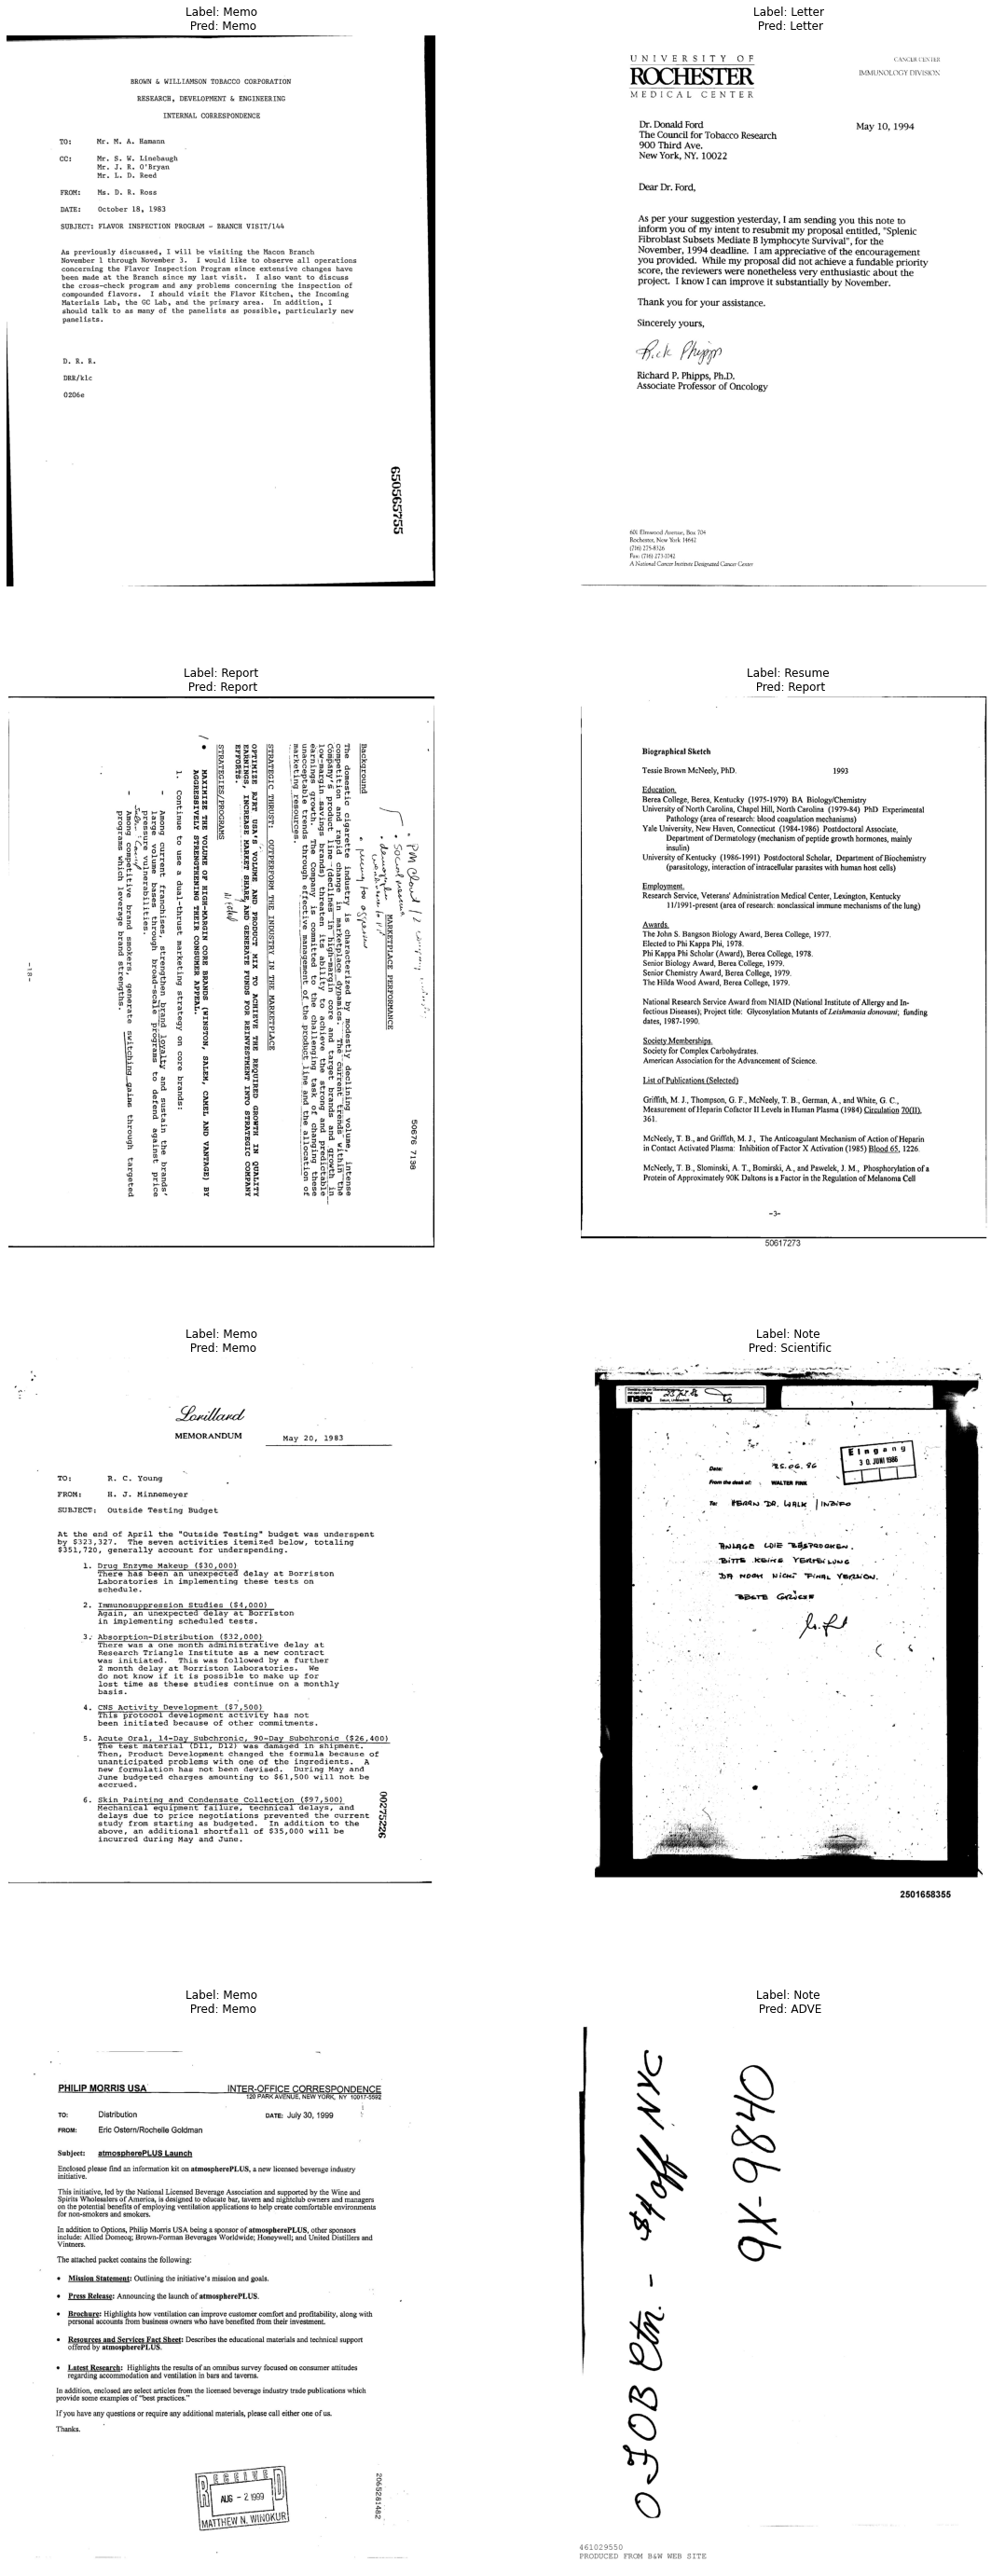

In [26]:
num_test = 8
cnt = 1

plt.figure(figsize=(20,50))
while cnt<=8:
    k = np.random.randint(len(test_df))
    label = test_df.label.iloc[k]
    im = Image.open(test_df.image_path.iloc[k]).convert("RGB")
    try:
        pred = infer(im, id2label, model, processor)
    except Exception as e:
        continue
        
    plt.subplot(int(num_test/2),2,cnt)
    plt.imshow(im)
    plt.axis('off')
    plt.title(f"Label: {label}\n Pred: {pred}")
    cnt += 1

plt.show()

# Saving Model to disk

In [35]:
torch.save(model.state_dict(), './saved_model/tobacco_layoutlmv2/10_epochs/model.pth')

# Loading Model & inference

In [36]:
loaded_model = LayoutLMv2ForSequenceClassification.from_pretrained("microsoft/layoutlmv2-base-uncased", num_labels=len(labels))

loaded_model.load_state_dict(torch.load('./saved_model/tobacco_layoutlmv2/10_epochs/model.pth'))

Some weights of the model checkpoint at microsoft/layoutlmv2-base-uncased were not used when initializing LayoutLMv2ForSequenceClassification: ['layoutlmv2.visual.backbone.bottom_up.res4.10.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res3.3.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res2.0.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.14.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.2.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.6.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.21.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.19.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res2.0.shortcut.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.22.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.17.conv1.norm.num_batches

Some weights of LayoutLMv2ForSequenceClassification were not initialized from the model checkpoint at microsoft/layoutlmv2-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

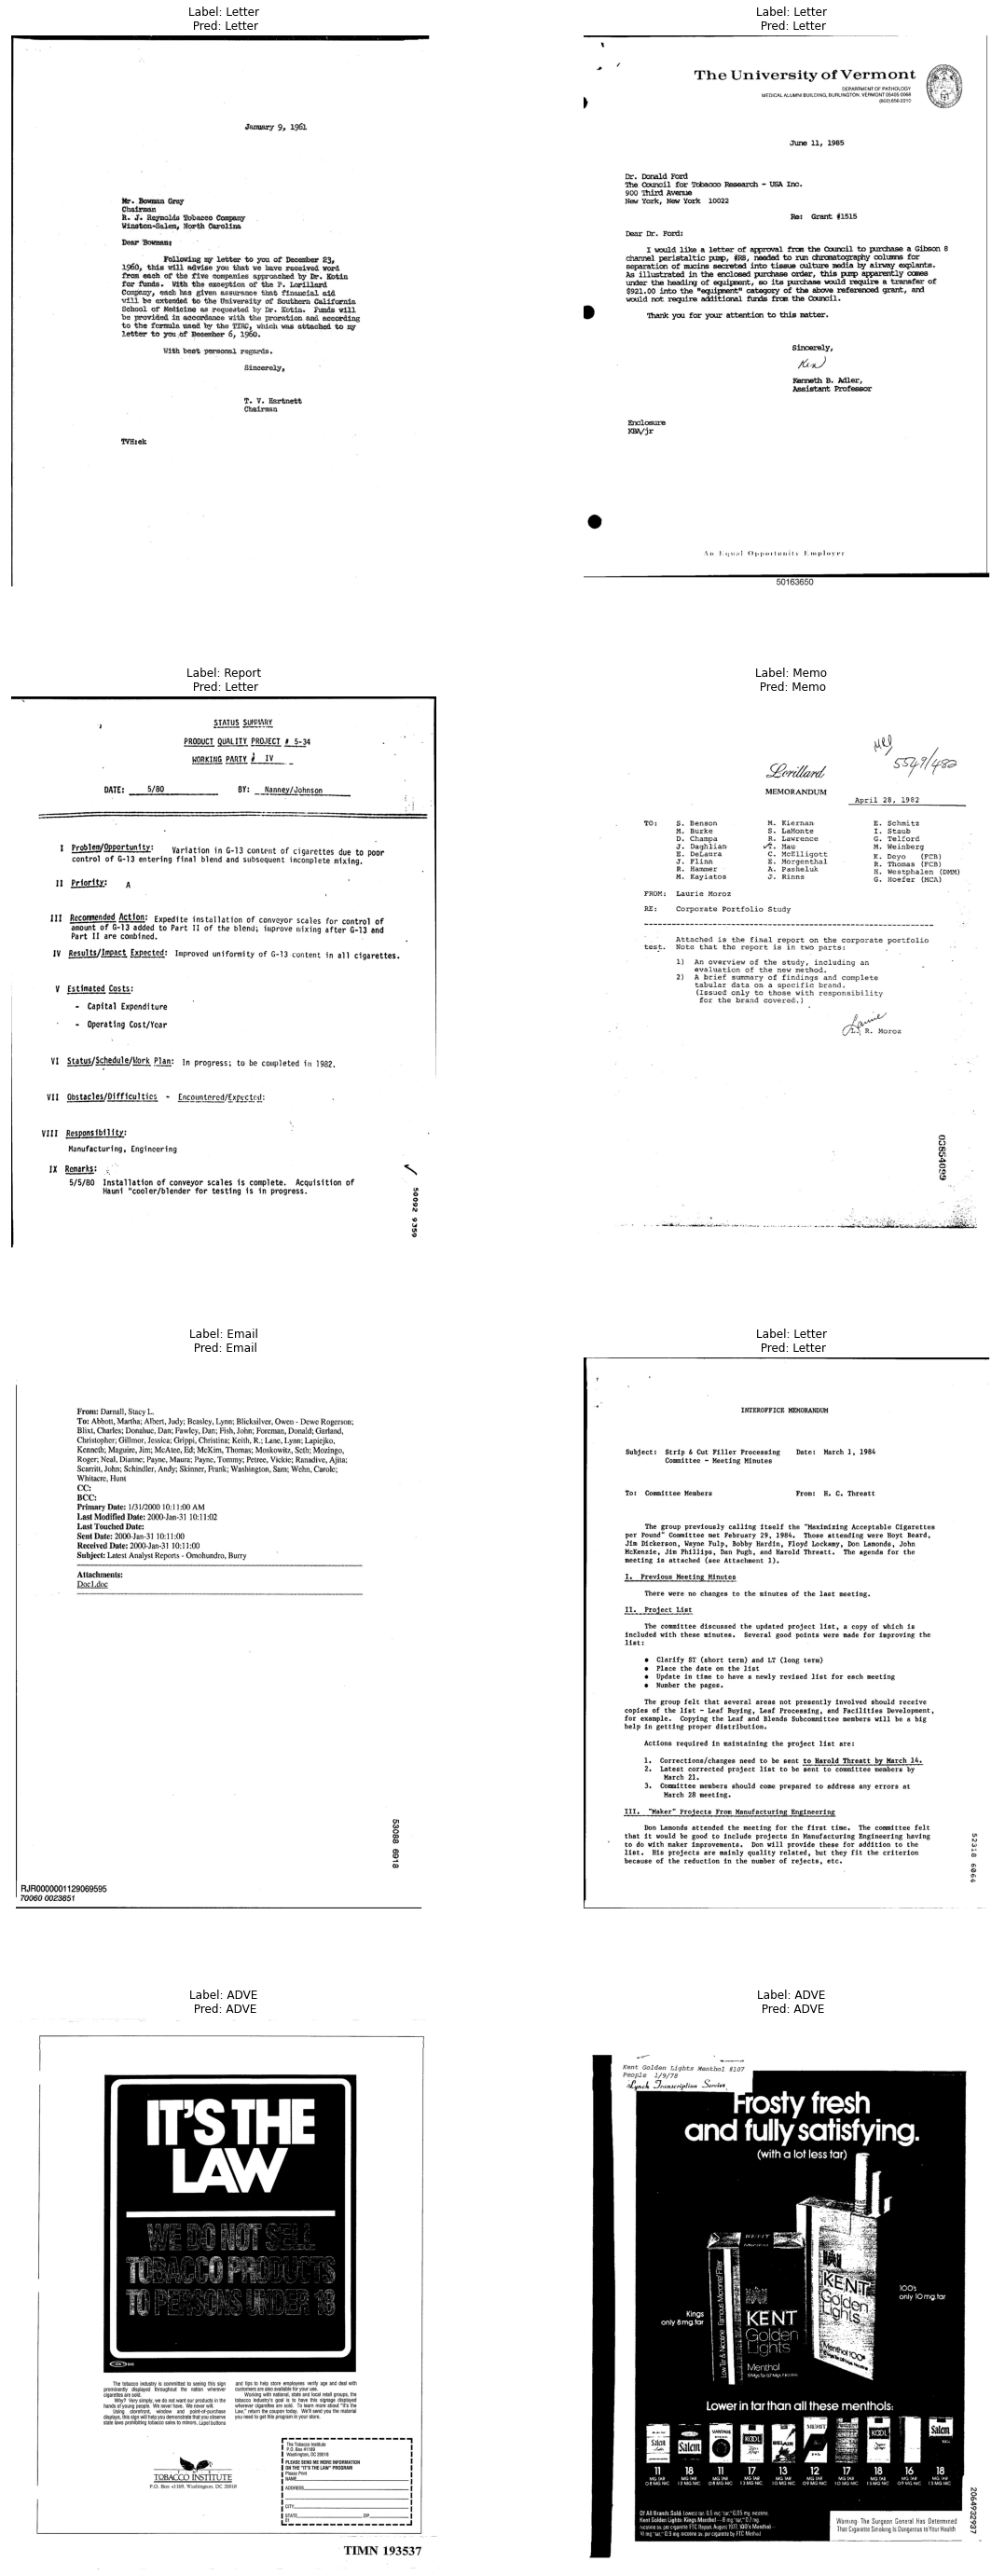

In [37]:
num_test = 8
cnt = 1

plt.figure(figsize=(20,50))
while cnt<=8:
    k = np.random.randint(len(test_df))
    label = test_df.label.iloc[k]
    im = Image.open(test_df.image_path.iloc[k]).convert("RGB")
    try:
        pred = infer(im, id2label, loaded_model, processor)
    except Exception as e:
        continue
        
    plt.subplot(int(num_test/2),2,cnt)
    plt.imshow(im)
    plt.axis('off')
    plt.title(f"Label: {label}\n Pred: {pred}")
    cnt += 1

plt.show()